# Table E3 The correlation between perc15 ratio and IEAs

In [1]:
import sys
sys.path.append("../../src/")
import IEA_model
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import utility

from importlib import reload 

from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 

# Loading data

In [2]:
df_bands = utility.load_perc15_bands()
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_merged = pd.merge(df_bands, df_IEA_test, left_index = True, right_index = True)

# Computing the logarithm of the ratio

In [3]:
peel_list = ["r0_5", "r5_10", "r10_15", "r15_20"]
core = "r20+"

res = []

for peel in peel_list:
    Q = np.log( df_merged[ peel + "_perc15" ] / df_merged[ core + "_perc15" ] )
    res.append(
        [ "{:.2f}".format( df_merged["IEA0"].corr( Q ) ),
          "{:.2f}".format( df_merged["IEA1"].corr( Q ) )
        ]
    )
    
res = np.array(res)    

# Generating the table

In [4]:
row_labels = ["log( perc15$_{R=0-5}$/perc15$_{R=20+}$)", 
             "log( perc15$_{R=5-10}$/perc15$_{R=20+}$)", 
             "log( perc15$_{R=10-15}$/perc15$_{R=20+}$)",
             "log( perc15$_{R=15-20}$/perc15$_{R=20+}$)",
            ] 

col_labels = ["IEA$_{emph}$", "IEA$_{airway}$"]

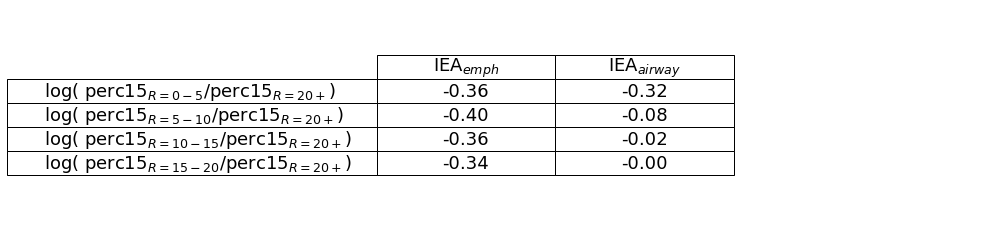

In [5]:
plt.figure(figsize=(16,4))
the_table=plt.table(cellText=res, rowLabels=row_labels, colLabels = col_labels,
                    colWidths = [.1]*res.shape[1], loc='center',cellLoc = "center")
plt.axis('off')
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)